In [1]:
%reload_ext autoreload
%autoreload 2

In [10]:

import os
import sys
import seaborn as sns

import pandas as pd
from gensim import corpora, models
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/neba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/neba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [8]:
# Initialize DataLoader
sl = SlackDataLoader('../Anonymized_B6SlackExport_25Nov23/anonymized/')

In [9]:
# converting all json files for all-community-building channel to dataframe using slack_parser method from loader script
df_community = sl.slack_parser('../Anonymized_B6SlackExport_25Nov23/anonymized/all-community-building/')

### plot histogram of the time difference between Consecutive messages


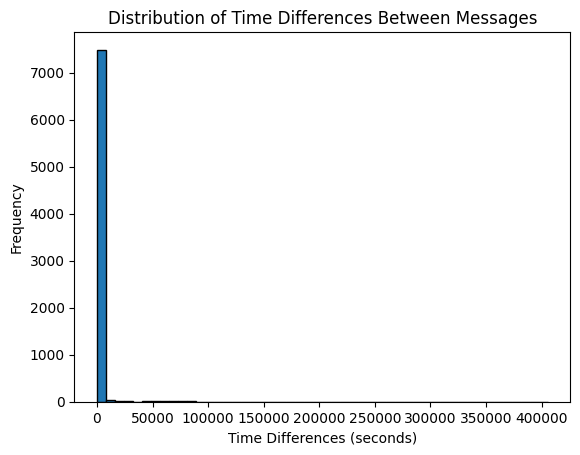

In [11]:
# Assuming df is your DataFrame with columns 'message' and 'message_sent_time'
# Convert 'message_sent_time' to datetime format
# df['message_sent_time'] = pd.to_datetime(df['message_sent_time'])
df_community['msg_sent_time'] = pd.to_datetime(df_community['msg_sent_time'], unit='s')

# Sort the DataFrame by 'message_sent_time'
df_community = df_community.sort_values(by='msg_sent_time')

# Calculate time differences between consecutive messages
df_community['time_difference'] = df_community['msg_sent_time'].diff()

# Plot the distribution of time differences
plt.hist(df_community['time_difference'].dt.total_seconds(), bins=50, edgecolor='black')
plt.xlabel('Time Differences (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences Between Messages')
plt.show()
